In [106]:
import alphashape
import numpy as np
import os
import pandas as pd


def make_alpha_hull(xy, alpha=1):
    alpha_shape = alphashape.alphashape(xy, alpha)
    xH, yH = alpha_shape.boundary.coords.xy
    return np.vstack([xH, yH]).T


df_kmeans = pd.read_csv(os.path.join('data', 'embeddings', 'polymers-umap-kmeans.txt'), header=None,
                        names=['Sequence', 'Z0', 'Z1'])
df_random = pd.read_csv(os.path.join('data', 'embeddings', 'polymers-umap-random.txt'), header=None,
                        names=['Sequence', 'Z0', 'Z1']).iloc[0:511]  # no renders after this
df = pd.concat([df_kmeans, df_random])

orig_hull = make_alpha_hull(df.loc[:, 'Z0':'Z1'])

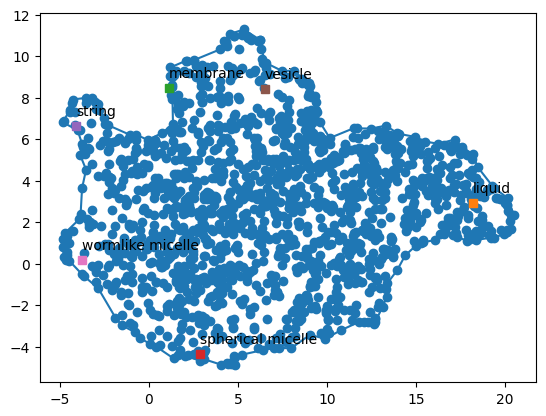

In [107]:
from matplotlib import pyplot as plt
from target_defs import archetype_predictions as arch

fig, ax = plt.subplots()
ax.plot(*orig_hull.T)
ax.scatter(*df.loc[:, 'Z0':'Z1'].values.T)

# show the archetypes
arch = {k: v for k, v in arch.items() if '_' not in k}
for k, v in arch.items():
    ax.plot(*v, 's')
    ax.text(*(v+np.array([0, 0.5])), k)

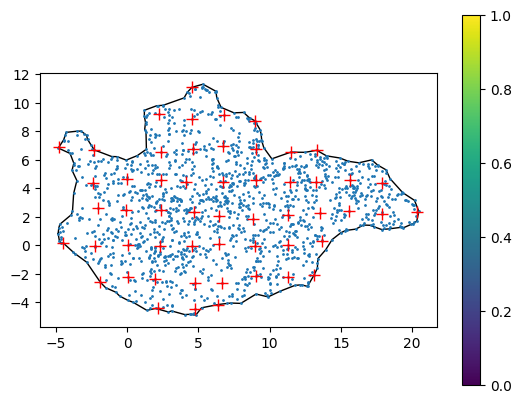

In [208]:
import numpy as np

def make_range(x, res):
    x_bot = np.floor(x.min()/res)*res
    x_top = np.ceil(x.max()/res)*res
    return np.arange(x_bot, x_top+1e-8, res)

def make_grid_2d(x, y, res, p=None):
    # make the full grid
    xg, yg = np.meshgrid(*[make_range(it, res) for it in (x, y)])
    xyg = np.vstack([xg.flatten(), yg.flatten()]).T
    # select the data closest to each grid point
    if p is None:
        p = np.zeros_like(x).reshape(-1, 1)
    xy = np.vstack([x, y]).T
    dists = [np.linalg.norm(xy + p - it, axis=1) for it in xyg]
    d_max = res/4
    best_idx = [np.argmin(it) for it in dists if it.min() < d_max]
    return best_idx

x, y = df.loc[:, 'Z0':'Z1'].values.T
xy = np.vstack([x, y]).T
res = 2.24

best_idx = make_grid_2d(x, y, res)

fig, ax = plt.subplots()
ax.plot(*orig_hull.T, 'k-', lw=1, zorder=0)
im = ax.scatter(x, y, s=1)
plt.colorbar(im)
ax.set_aspect('equal')

ax.plot(*xy[best_idx].T, 'r+', ms=8)

In [207]:
from scipy import spatial

dist = spatial.distance.squareform(spatial.distance.pdist(xy[best_idx]))
dist[np.eye(dist.shape[0]).astype(bool)] = np.nan
print(np.mean(np.nanmin(dist, axis=1)))
print(np.median(np.nanmin(dist, axis=1)))

0.6438174337652061
0.5932805237490955


In [198]:
import os

roar_prefix = "/storage/group/wfr5091/default/polymers-data/polymers-2021/"
sequences = df.loc[:, 'Sequence'].iloc[best_idx].values.tolist()
snapshots = [f'Npol_500_Nmon_20_seq_{it}_run_0_traj_box_43.1_43.1_43.1_kT_0.5.gsd' for it in sequences]
print(len(snapshots))

suffix = "_2021"
with open(f'to_render_res{res:.2f}{suffix}.txt', 'w') as fid:
    fid.write('\n'.join([os.path.join(roar_prefix, it) for it in snapshots]))

54


100%|██████████| 107/107 [00:02<00:00, 53.29it/s]


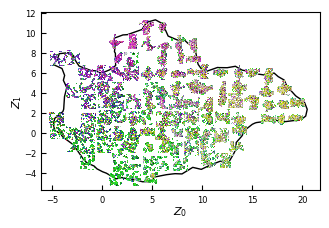

In [276]:
import glob
from matplotlib import pyplot as plt
from matplotlib import offsetbox
import tqdm

def make_annotated_umap(data, image_path):
    fig, ax = plt.subplots(figsize=(3.6, 2.4))
    ax.plot(*orig_hull.T, 'k-', lw=1, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlabel('$Z_0$', labelpad=0, fontsize=8)
    ax.set_ylabel('$Z_1$', labelpad=0, fontsize=8)
    ax.tick_params(which='both', direction='in')
    # ax.set_xticks(ax.get_xticks())
    # ax.set_xticklabels(ax.get_xticklabels(), fontsize=6)
    # ax.set_yticks(ax.get_yticks())
    # ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)
    
    png_files = sorted(glob.glob(f'{image_path}/*.png'))
    txt_files = sorted(glob.glob(f'{image_path}/*.txt'))
    with open(txt_files[0], 'r') as fid:
        filenames = [it.split('/')[-1].strip() for it in fid.readlines()]
    
    prog = tqdm.tqdm(enumerate(png_files), total=len(png_files))
    for i, png in prog:
        
        arr_img = plt.imread(png, format='png')
     
        arr_img[arr_img[:, :, :-1].min(axis=2) > 0.95, -1] = 0.0
     
        seq = filenames[i].split('_seq_')[1].split('_run_')[0]
        idx = df['Sequence'] == seq
        xy = data.loc[idx, 'Z0':'Z1'].values[0].flatten()
    
        imagebox = offsetbox.OffsetImage(arr_img, zoom=0.020)
        imagebox.image.axes = ax
    
        ab = offsetbox.AnnotationBbox(imagebox, xy, xycoords='data', frameon=False, zorder=1)
        
        ax.add_artist(ab)
        
    return fig

image_path = os.path.join('data', 'snapshots')
fig = make_annotated_umap(df, image_path)

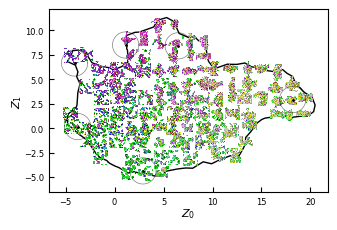

In [277]:
t = np.linspace(0, 2*np.pi)
circ_points = np.vstack([np.cos(t), np.sin(t)]).T  # radius = 1

arch = {k: v for k, v in arch.items() if '_' not in k}
for k, v in arch.items():
    fig.gca().plot(*v, 'k.', ms=2)
    # fig.gca().plot(*(0.67 * circ_points + v).T, 'k-', alpha=0.5)
    fig.gca().plot(*(1.34 * circ_points + v).T, 'k-', alpha=0.5, lw=0.5)
    # fig.gca().text(*(v+np.array([0, 0.5])), k)
fig

In [278]:
fig.savefig(os.path.join("figures", "grid_134.pdf"), dpi=600, bbox_inches='tight')

In [161]:
d_targets = np.arange(0.0, 6.1, 0.6)
z = df.loc[:, 'Z0':'Z1'].values
cent = np.mean(z, axis=0)

for j, (k, v) in enumerate(arch.items()):
    
    render_sequences = [] 
    for r in d_targets:
        # t = v + r * (cent - v) / np.linalg.norm(cent - v)
        # d_to_line = np.linalg.norm(t - z, axis=1)
        d_to_line = np.abs(np.linalg.norm(v - z, axis=1) - r)
        i = np.argmin(d_to_line)
        d = np.linalg.norm(v - z, axis=1)
        if np.abs(d[i] - r) < 0.20:
            print(f'{r:.2f} {d[i]:.2f} {df.iloc[i, 0]} {df.iloc[i, 1:].values}')
            render_sequences.append([r, i, df.iloc[i, 0], d[i], *df.iloc[i, 1:].values])
        else:
            render_sequences.append([None]*6)
    
    pd.DataFrame(render_sequences, columns=['Target', 'Index', 'Sequence', 'Distance', 'Z0', 'Z1']).to_csv(f'render-{k}.csv')
    print(k, len(render_sequences))

0.00 0.02 ABABBAAABABABAABAABA [18.154593 2.926049]
0.60 0.62 BAABBAABABAABAABAABA [17.916721 2.367133]
1.20 1.18 ABBAABABABAABAABABAA [17.110302 3.44529]
1.80 1.79 BABAABABAABAABAAABAB [18.373573 1.149347]
2.40 2.40 BAAAAABBBBBAABAAABAA [16.316414 1.412972]
3.00 3.00 ABAAABBBABBAAABAAABA [15.288886 2.132147]
3.60 3.60 BAABBBAAABABAAABAABA [14.600779 3.342193]
4.20 4.18 ABBABAAAABAABBAABABA [15.089442 5.755188]
4.80 4.79 ABAABABAABAAABABBBAA [14.166949 5.551137]
5.40 5.40 ABBAAAABAABABABBAABA [13.949774 6.295513]
6.00 6.01 AABAABBABABABABAABAA [13.18363 6.284253]
liquid 11
0.00 0.19 BAABAABBAABAAABBBAAA [1.316599 8.527619]
0.60 0.57 BAABAABBAAAABBBAABAA [1.328665 7.962733]
1.20 1.20 ABBAAABAAAABBBABABAA [1.940332 7.616981]
1.80 1.79 ABBABBAABAAABAAABBAA [2.872722 8.093736]
2.40 2.38 BABBBBAAAABAABAABAAA [3.457089 8.001224]
3.00 3.00 BAAABABAAABABBBABAAA [-0.021163 5.727423]
3.60 3.60 BBABABABAABAAAABABAA [2.954301 5.394972]
4.20 4.19 ABABAAAABABABBBABAAA [2.042892 4.404345]
4.80 4.81 A

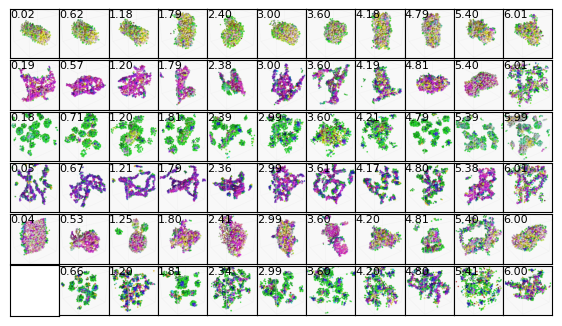

In [162]:
import glob
import os
from PIL import Image

drive_prefix = '/Users/wfr5091/Google Drive/Shared Drives/Polymers-Data/trajectories/full-space'

fig, axes = plt.subplots(len(arch), len(d_targets), figsize=(7, 4),
                         sharex='all', sharey='all')
fig.subplots_adjust(hspace=0, wspace=0)

for j, (k, v) in enumerate(arch.items()):
    morph_df = pd.read_csv(f'render-{k}.csv', index_col=0)
    for k, idx in enumerate(morph_df.index):
        d = morph_df.loc[idx, 'Distance']
        if d != d:
            continue
        s = str(morph_df.loc[idx, 'Sequence'])
        i = int(morph_df.loc[idx, 'Index']) 
        if s in df_kmeans['Sequence'].tolist():
            subdir = 'AB-N500-kmeans-1024'
            img = os.path.join(drive_prefix, subdir, 'renders', f'spheres-{i:05d}.png')
        elif s in df_random['Sequence'].tolist():
            subdir = 'AB-N500-random-1024'
            # img = os.path.join(drive_prefix, subdir, 'renders', f'spheres-{i-len(df_kmeans):05d}-{s}.png')
            valid_files = glob.glob(os.path.join(drive_prefix, subdir, 'renders', f'spheres-*-{s}.png'))
            if len(valid_files) == 1:
                img = valid_files[0]
            else:
                raise ValueError(valid_files)
        else:
            raise ValueError('Sequence not found in either DataFrame.')
        
        img_arr = np.array(Image.open(img))
        ax = axes[j, k]
        ax.imshow(img_arr)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(0, 0, f'{d:.2f}', ha='left', va='top', fontsize=8)

In [163]:
fig.savefig('test-distances.pdf', dpi=600)